<a href="https://colab.research.google.com/github/1900690/eye-camera/blob/main/eye_camera_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
name = "ベテランパック詰め"
shutil.copy("/content/drive/MyDrive/itigo/"+name+".mp4","/content/"+name+".mp4")
shutil.copy("/content/drive/MyDrive/itigo/"+name+".json","/content/"+name+".json")

'/content/ベテランパック詰め.json'

#十字印付け

In [ ]:
from pandas.core.base import doc
import shutil
import os
from google.colab import files
import pandas as pd
from PIL import Image
import cv2

#uploaded = files.upload()
#filename = os.path.splitext(list(uploaded.keys())[0])[0]
filename = "ベテランパック詰め"

#視線データを読み込み必要な部分を抽出
json_file = "/content/"+filename+".json"
df = pd.read_json(json_file)
df2=df["EyeData"].iloc[2]
df3 = pd.json_normalize(df2)
df6=df3[['recomValid','recomPoint.x','recomPoint.y']]

# 動画ファイルのキャプチャー
cap = cv2.VideoCapture("/content/"+filename+".mp4")

# 動画ファイルのフレームレート取得
fps = cap.get(cv2.CAP_PROP_FPS)

#動画のサイズを取得
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width,height)
point_size=max(width,height)

# 保存用動画ファイルのフォーマット設定
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter("/content/"+filename+"_eye_point.mp4", fourcc, fps, size)

# 動画を1コマずつ取り込んで処理
while(cap.isOpened()):
    ret, frame = cap.read() # キャプチャー画像の取り込み

    if ret==True: # キャプチャー画像がある場合
        # 現在時間を取得
        time = cap.get(cv2.CAP_PROP_POS_MSEC)

        # 現在のフレーム数を取得
        frame_n = cap.get(cv2.CAP_PROP_POS_FRAMES)

        # 視点を描画
        cv2.drawMarker(frame, (int(df6.loc[int(frame_n)][1]*width),int(df6.loc[int(frame_n)][2]*height)), (0, 0, 255),cv2.MARKER_CROSS,int(point_size/10),int(point_size/100))
        print((int(df6.loc[int(frame_n)][1]*width),int(df6.loc[int(frame_n)][2]*height)))

        # mp4動画を保存
        out.write(frame)

    else: # キャプチャー画像がない場合はループ終了
        break

cap.release() # 再生画像をクローズ
out.release() # 出力動画ファイルをクローズ
#files.download("/content/"+filename+"_eye_point.mp4")

<ipython-input-9-c089dfc0a50e>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1280x960', '-pix_fmt', 'rgba', '-r', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'animation.mp4']' returned non-zero exit status 255.

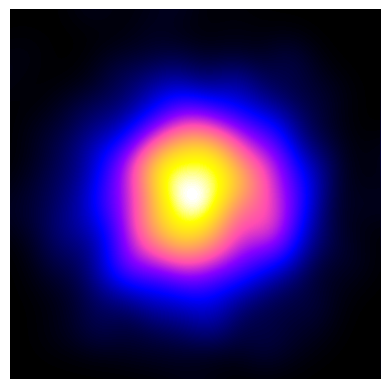

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from matplotlib import animation

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig = plt.figure()
ax = plt.axes(xlim=(-3, 3), ylim=(-3, 3))
plt.grid(False)
plt.axis(False)

def init():
    x = np.random.randn(1000)
    y = np.random.randn(1000)
    img, extent = myplot(x, y, 50)
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.gnuplot2)

def animate(i):
    x = np.random.randn(1000)
    y = np.random.randn(1000)
    img, extent = myplot(x, y, 50)
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.gnuplot2)
anim = animation.FuncAnimation(fig, animate, init_func = init, frames=150,
                               interval=30, repeat = False)

anim.save('animation.mp4', fps=30, dpi=200)
plt.close()

In [11]:
import cv2
import numpy as np
from tqdm import tqdm

def GaussianMask(sizex,sizey, sigma=33, center=None,fix=1):
    """
    sizex  : mask width
    sizey  : mask height
    sigma  : gaussian Sd
    center : gaussian mean
    fix    : gaussian max
    return gaussian mask
    """
    x = np.arange(0, sizex, 1, float)
    y = np.arange(0, sizey, 1, float)
    x, y = np.meshgrid(x,y)

    if center is None:
        x0 = sizex // 2
        y0 = sizey // 2
    else:
        if np.isnan(center[0])==False and np.isnan(center[1])==False:
            x0 = center[0]
            y0 = center[1]
        else:
            return np.zeros((sizey,sizex))

    return fix*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / sigma**2)

def Fixpos2Densemap(fix_arr, width, height, imgfile, alpha=0.5, threshold=10):
    """
    fix_arr   : fixation array number of subjects x 3(x,y,fixation)
    width     : output image width
    height    : output image height
    imgfile   : image file (optional)
    alpha     : marge rate imgfile and heatmap (optional)
    threshold : heatmap threshold(0~255)
    return heatmap
    """

    heatmap = np.zeros((H,W), np.float32)
    for n_subject in tqdm(range(fix_arr.shape[0])):
        heatmap += GaussianMask(W, H, 33, (fix_arr[n_subject,0],fix_arr[n_subject,1]),
                                fix_arr[n_subject,2])

    # Normalization
    heatmap = heatmap/np.amax(heatmap)
    heatmap = heatmap*255
    heatmap = heatmap.astype("uint8")

    if imgfile.any():
        # Resize heatmap to imgfile shape
        h, w, _ = imgfile.shape
        heatmap = cv2.resize(heatmap, (w, h))
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Create mask
        mask = np.where(heatmap<=threshold, 1, 0)
        mask = np.reshape(mask, (h, w, 1))
        mask = np.repeat(mask, 3, axis=2)

        # Marge images
        marge = imgfile*mask + heatmap_color*(1-mask)
        marge = marge.astype("uint8")
        marge = cv2.addWeighted(imgfile, 1-alpha, marge,alpha,0)
        return marge

    else:
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        return heatmap

if __name__ == '__main__':
    # Load image file
    img = cv2.imread('/content/sample.png')

    # Generate toy fixation data
    # when you use, replace here with your data
    num_subjects = 40
    H, W, _ = img.shape

    fix_arr = np.random.randn(num_subjects,3)
    fix_arr -= fix_arr.min()
    fix_arr /= fix_arr.max()
    fix_arr[:,0] *= W
    fix_arr[:,1] *= H

    # Create heatmap
    heatmap = Fixpos2Densemap(fix_arr, W, H, img, 0.7, 5)
    cv2.imwrite("output.png",heatmap)

100%|██████████| 40/40 [00:00<00:00, 186.38it/s]
